**In this notebook, we will try a Linear Regression Model**

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from empiricaldist import Pmf, Cdf
from matplotlib.ticker import MaxNLocator
%matplotlib inline  
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# for one hot encoding with feature-engine
from feature_engine.categorical_encoders import OneHotCategoricalEncoder
from feature_engine.categorical_encoders import RareLabelCategoricalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
import scipy.stats as stats
from feature_engine import variable_transformers as vt
from sklearn.preprocessing import StandardScaler

In [2]:
train_data = pd.read_csv("train.csv")

In [3]:
# imputing missing data as in baseline model

train_data["LotFrontage"] = train_data["LotFrontage"].fillna(train_data["LotFrontage"].median())
train_data["MasVnrArea"] = train_data["MasVnrArea"].fillna(train_data["MasVnrArea"].median())

train_data["MasVnrType"] = train_data["MasVnrType"].fillna(train_data["MasVnrType"].mode())
train_data["Electrical"] = train_data["Electrical"].fillna(train_data["Electrical"].mode())

cat_cols= [x for x in train_data.columns if train_data[x].dtype==np.object]
train_data[cat_cols]=train_data[cat_cols].fillna("NA")
train_data.drop("GarageYrBlt", axis=1, inplace=True)

In [4]:
# transforming all area features using YeoJohnson transformation

area_cols = [x for x in train_data.columns if ("SF" in x)|("Area" in x)|(x=="LotFrontage")]
area_cols

yjt = vt.YeoJohnsonTransformer(variables = area_cols)
yjt.fit(train_data)
print("these are the exponents for the Yeo-Johnson transformation: {}".format(yjt.lambda_dict_))

these are the exponents for the Yeo-Johnson transformation: {'LotFrontage': 0.4155172353595565, 'LotArea': 0.03081854079393649, 'MasVnrArea': -0.24430146914434417, 'BsmtFinSF1': 0.22872562524018467, 'BsmtFinSF2': -1.5215505484996374, 'BsmtUnfSF': 0.4712723599394073, 'TotalBsmtSF': 0.7396016878493652, '1stFlrSF': -0.07987709830415687, '2ndFlrSF': -0.12741730779016755, 'LowQualFinSF': -10.018636837166552, 'GrLivArea': 0.005539641278705955, 'GarageArea': 0.8112580246118668, 'WoodDeckSF': -0.078596115085857, 'OpenPorchSF': 0.011642789763656977, 'PoolArea': -32.86118772770139}


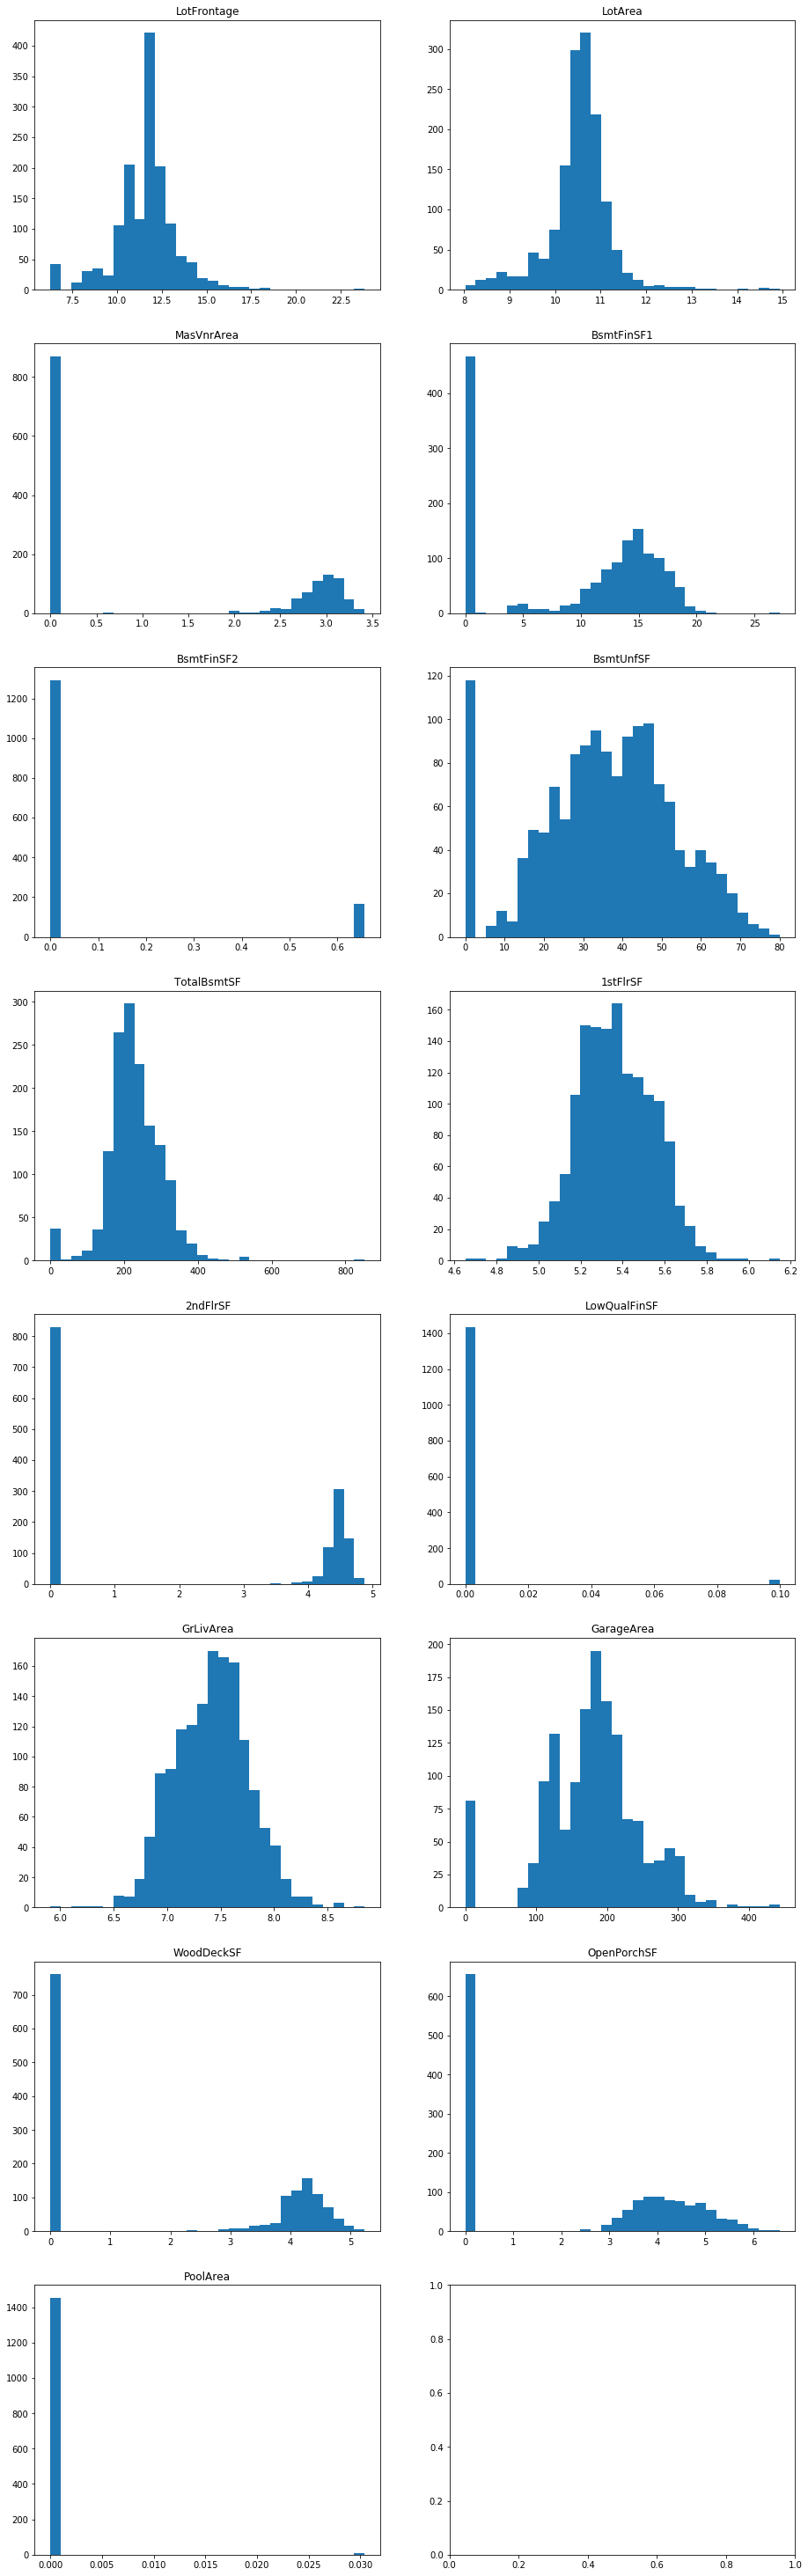

In [5]:
train_data_tf = yjt.transform(train_data)

# plot distribution of area_cols after transformation

if len(area_cols)%2==0:
    nrows=len(area_cols)//2
else:
    nrows=len(area_cols)//2 + 1
    
fig, axes = plt.subplots(nrows,2, figsize=(15,50))
row=0 
col=0
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

for column in area_cols:
    
    axes[row,col].hist(train_data_tf[column], bins=30)
    axes[row,col].set_title(column)
   
    
    if col==0:
        col=col+1
        
    else:
        row=row+1
        col=0

In [6]:
# Applying rare label encoding

rare_encoder = RareLabelCategoricalEncoder(
    tol=0.05,  # minimal percentage to be considered non-rare
    n_categories=4, # minimal number of categories the variable should have to re-cgroup rare categories
    variables=cat_cols # apply to all categorical columns
) 

rare_encoder.fit(train_data_tf)
train_data_tf = rare_encoder.transform(train_data_tf)


In [7]:
train_data_tf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1460 non-null float64
LotArea          1460 non-null float64
Street           1460 non-null object
Alley            1460 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 n

**Baseline model for linear Regression**
this model will only include:
1. 10 most correlated (numerical) features from the EDA notebook (include area features which were transformed):
   OverallQual, GrLivArea, GarageCars, GarageArea,
   TotalBsmtSF, 1stFlrSF, FullBath, TotRmsAbvGrd, YearBuilt,
   YearRemodAdd]
2. Standardize thos 10 features

In [17]:
highest_corr_cols = ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt',
       'YearRemodAdd']
num_cols = [col for col in train_data_tf.columns if col not in cat_cols]

X = train_data_tf[num_cols]
y = train_data_tf['SalePrice']

In [18]:
X.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,11.573739,10.524159,6.099315,5.575342,1971.267808,1984.865753,1.185173,9.585676,0.075145,35.882481,227.656989,5.364513,1.932616,0.001778,7.417149,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1.767123,177.651702,2.017697,2.367526,21.954110,3.409589,15.060959,0.000146,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,1.759741,0.684708,1.382997,1.112799,30.202904,20.645407,1.448562,7.086354,0.209166,17.390176,72.724356,0.181261,2.218450,0.013205,0.346996,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,0.747315,70.006472,2.123867,2.210699,61.119149,29.317331,55.757415,0.002103,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,6.287182,8.025002,1.000000,1.000000,1872.000000,1950.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,4.650868,-0.000000,-0.000000,5.908775,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,10.874835,10.279607,5.000000,5.000000,1954.000000,1967.000000,-0.000000,0.000000,-0.000000,25.063437,187.805957,5.237027,-0.000000,-0.000000,7.169113,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1.000000,136.750899,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,11.656459,10.579554,6.000000,5.000000,1973.000000,1994.000000,-0.000000,12.685519,-0.000000,36.754104,221.178164,5.357459,-0.000000,-0.000000,7.438796,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,2.000000,183.588940,-0.000000,3.320681,0.000000,0.000000,0.000000,-0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,12.458797,10.848369,7.000000,6.000000,2000.000000,2004.000000,2.917921,15.274878,-0.000000,47.670569,270.225865,5.497138,4.459704,-0.000000,7.640370,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2.000000,212.990807,4.221773,4.340207,0.000000,0.000000,0.000000,-0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,23.831212,14.926126,10.000000,9.000000,2010.000000,2010.000000,3.418408,27.162515,0.657214,79.966859,852.174681,6.146688,4.880892,0.099814,8.848186,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,4.000000,443.308535,5.240922,6.543559,552.000000,508.000000,480.000000,0.030431,15500.000000,12.000000,2010.000000,755000.000000


In [19]:
y.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [20]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 37 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
LotFrontage      1460 non-null float64
LotArea          1460 non-null float64
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
MasVnrArea       1460 non-null float64
BsmtFinSF1       1460 non-null float64
BsmtFinSF2       1460 non-null float64
BsmtUnfSF        1460 non-null float64
TotalBsmtSF      1460 non-null float64
1stFlrSF         1460 non-null float64
2ndFlrSF         1460 non-null float64
LowQualFinSF     1460 non-null float64
GrLivArea        1460 non-null float64
BsmtFullBath     1460 non-null int64
BsmtHalfBath     1460 non-null int64
FullBath         1460 non-null int64
HalfBath         1460 non-null int64
BedroomAbvGr     1460 non-null int64
KitchenAbvGr     1460 non-null int64
TotRmsAbvGrd     146

In [21]:
# set up the scaler
scaler = StandardScaler()

# fit the scaler to the train set, it will learn the parameters
scaler.fit(X)

# transform 
X_scaled = scaler.transform(X)

In [23]:
pd.DataFrame(X_scaled).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36
count,1460.000000,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03
mean,0.000000,-8.455945e-17,5.243903e-16,4.380058e-17,1.387018e-16,3.540547e-16,1.046347e-15,4.496860e-15,7.300097e-17,-5.110068e-17,-6.448419e-17,2.068361e-16,4.647728e-16,-2.670619e-15,-3.802134e-17,-7.056760e-17,1.898025e-15,2.311697e-17,2.433366e-17,1.180182e-16,2.083569e-17,2.141362e-16,4.501726e-16,-1.022014e-16,-4.866731e-18,1.216683e-16,-1.447852e-16,1.460019e-17,1.204516e-16,-2.311697e-17,4.866731e-18,5.475072e-17,-1.946692e-17,-2.676702e-17,7.543433e-17,3.567436e-14,1.362685e-16
std,1.000343,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00
min,-1.730865,-8.725628e-01,-3.005196e+00,-3.651210e+00,-3.688413e+00,-4.112970e+00,-3.287824e+00,-1.689368e+00,-8.184522e-01,-1.353159e+00,-3.593841e-01,-2.064084e+00,-3.131482e+00,-3.938455e+00,-8.714543e-01,-1.346518e-01,-4.348434e+00,-8.199644e-01,-2.410610e-01,-2.841822e+00,-7.616207e-01,-3.514952e+00,-4.751486e+00,-2.780469e+00,-9.512265e-01,-2.365440e+00,-2.538516e+00,-9.503365e-01,-1.071307e+00,-3.593249e-01,-1.163393e-01,-2.702084e-01,-6.940907e-02,-8.768781e-02,-1.969111e+00,-1.367655e+00,-1.838704e+00
25%,-0.865432,-8.725628e-01,-3.972990e-01,-3.572852e-01,-7.951515e-01,-5.171998e-01,-5.719226e-01,-8.656586e-01,-8.184522e-01,-1.353159e+00,-3.593841e-01,-6.223486e-01,-5.481614e-01,-7.035661e-01,-8.714543e-01,-1.346518e-01,-7.150539e-01,-8.199644e-01,-2.410610e-01,-1.026041e+00,-7.616207e-01,-1.062465e+00,-2.114536e-01,-9.341298e-01,-9.512265e-01,-1.026858e+00,-5.844434e-01,-9.503365e-01,-1.071307e+00,-3.593249e-01,-1.163393e-01,-2.702084e-01,-6.940907e-02,-8.768781e-02,-4.891101e-01,-6.144386e-01,-6.415162e-01
50%,0.000000,-1.631095e-01,4.702293e-02,8.093051e-02,-7.183611e-02,-5.171998e-01,5.737148e-02,4.425864e-01,-8.184522e-01,4.375882e-01,-3.593841e-01,5.013873e-02,-8.911794e-02,-3.893190e-02,-8.714543e-01,-1.346518e-01,6.240474e-02,-8.199644e-01,-2.410610e-01,7.897405e-01,-7.616207e-01,1.637791e-01,-2.114536e-01,-3.186833e-01,6.004949e-01,3.117246e-01,8.483890e-02,-9.503365e-01,4.313029e-01,-3.593249e-01,-1.163393e-01,-2.702084e-01,-6.940907e-02,-8.768781e-02,-1.191097e-01,1.387775e-01,-2.256643e-01
75%,0.865432,3.098594e-01,5.031201e-01,4.736638e-01,6.514792e-01,3.817427e-01,9.516316e-01,9.271216e-01,1.196595e+00,8.031142e-01,-3.593841e-01,6.780913e-01,5.855461e-01,7.319279e-01,1.139514e+00,-1.346518e-01,6.435164e-01,1.107810e+00,-2.410610e-01,7.897405e-01,1.227585e+00,1.637791e-01,-2.114536e-01,2.967633e-01,6.004949e-01,3.117246e-01,5.049706e-01,1.038121e+00,8.926390e-01,-3.593249e-01,-1.163393e-01,-2.702084e-01,-6.940907e-02,-8.768781e-02,6.208910e-01,8.919936e-01,4.165294e-01
max,1.730865,3.147673e+00,6.967884e+00,6.431170e+00,2.821425e+00,3.078570e+00,1.282839e+00,1.217843e+00,1.542220e+00,2.481228e+00,2.783766e+00,2.535885e+00,8.590405e+00,4.316660e+00,1.329436e+00,7.426564e+00,4.125483e+00,4.963359e+00,8.138680e+00,2.605522e+00,3.216791e+00,6.294997e+00,8.868612e+00,4.604889e+00,3.703938e+00,2.988889e+00,3.796047e+00,1.518141e+00,1.889657e+00,8.675309e+00,1.721723e+01,8.341

In [29]:
lr = LinearRegression(fit_intercept=False)
scores = cross_val_score(lr, X, y, cv=5, scoring='neg_mean_squared_log_error')
scores = np.sqrt(np.abs(scores))
print("RMSLE: {} (+/- {})".format(scores.mean(), scores.std() * 2))

RMSLE: 1.1284651388793411e-15 (+/- 5.404928347159652e-16)


In [30]:
scores

array([1.49562928e-15, 1.20334785e-15, 1.29837781e-15, 7.56792329e-16,
       8.88178420e-16])